In [1]:
import os
import time
import scipy
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
onColab = True
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE1/with_img_divided/moreDivision
  !ls

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/14nAfiUIlOkzENFAyByV5FH1KxQM8uSlm/CHALLENGE1/with_img_divided/moreDivision
 ckpt_mynet_trial_1_moreDivisionDS   model.png
 ckpt_mynet_trial_2_moreDivisionDS   training
'Copia di my_net.ipynb'		     training.zip
'Copia di mynet_trial_2.ipynb'


In [3]:
doUnzipData = False
batch_size = 128
validation_split = 0.3

if doUnzipData:
  !unzip dataset.zip

In [4]:
#@title init seed everywhere
seed =20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
dataset_path = './training'
img_h, img_w = (256, 256)
test_path = './test'


def load_data(dontUseFun=True, fun=None, isTest = False):
  """
  load data (train, val, test)
  dontUseFun: if it's true then the data is not preprocessed. If it's false, the data is preprocessed with fun (which must not be none)
  """
  image_generator = ImageDataGenerator(preprocessing_function = fun, validation_split=validation_split, 
                                          rotation_range=30,
                                          height_shift_range=50,
                                          width_shift_range=50,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True, 
                                          fill_mode='reflect')  
  if dontUseFun:
    image_generator = ImageDataGenerator(validation_split=validation_split, 
                                          rotation_range=30,
                                          height_shift_range=50,
                                          width_shift_range=50,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True, 
                                          fill_mode='reflect')  


  # Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
  train_gen = image_generator.flow_from_directory(directory=dataset_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                subset='training',
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=seed)

  valid_gen = image_generator.flow_from_directory(directory=dataset_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                subset='validation',
                                                batch_size=batch_size,
                                                shuffle=False,
                                                seed=seed)
  test_gen = None
  if isTest:
    test_image_gen = ImageDataGenerator(preprocessing_function = fun)
    if dontUseFun:
      test_image_gen = ImageDataGenerator(rotation_range=30)
    
    test_gen = test_image_gen.flow_from_directory(directory=test_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                batch_size=batch_size,
                                                shuffle=True, # sometimes, instead of train, we use the test for training
                                                seed=seed)
  return train_gen, valid_gen, test_gen

In [6]:
# we need this ONLY for the labels
train_gen = load_data(True, None, False)[0]
labels = list(train_gen.class_indices.keys())


Found 12367 images belonging to 27 classes.
Found 5282 images belonging to 27 classes.


In [7]:
create_test_set = False

model_dir = 'mynet_trial_2_moreDivisionDS'

# Highly dependent on the network chosen:
n_not_trainable_layers = 0
buildModel = True

def tl_preprocess(x):
  # no preprocessing
  return x

def compute_weight(val_split):
  w = []
  for i in range(len(labels)):
    class_imgs = next(os.walk('{}/{}/'.format('./training', labels[i])))[2]
    w.append(len(class_imgs) * (1 - val_split))

  tot = sum(w)
  for i in range(len(w)):
    w[i] = tot / w[i]
  m = max(w)
  w = np.array(w) / m
  w[np.argmax(w)] = 0.99999999999999
  d = {}
  for i in range(len(w)):
    d[i] = w[i]
  return d

# weights computed for validation split = 0.3
class_weight = {0: 0.15611814345991562, 1: 0.15744680851063828, 2: 0.16554809843400448, 3: 0.2846153846153846, 4: 0.23197492163009406, 5: 0.2072829131652661, 6: 0.08820023837902265, 7: 0.24183006535947713, 8: 0.0647419072615923, 9: 0.05124653739612189, 10: 0.28030303030303033, 11: 0.2901960784313725, 12: 0.10292072322670377, 13: 0.164079822616408, 14: 0.2442244224422442, 15: 0.4157303370786517, 16: 0.1182108626198083, 17: 0.28136882129277563, 18: 0.056661562021439515, 19: 0.25517241379310346, 20: 0.13909774436090225, 21: 0.99999999999999, 22: 0.22289156626506024, 23: 0.26618705035971224, 24: 0.7708333333333335, 25: 0.1488933601609658, 26: 0.01443620756925478}

mappings = {
    0: 0, 1: 0,
    2: 1,
    3: 2, 4: 2,
    5: 3, 6: 3,
    7: 4, 8: 4,
    9: 5, 10: 5,
    11: 6, 12: 6,
    13: 7, 14: 7,
    15: 8, 16: 8,
    17: 9, 
    18: 10, 19:10,
    20: 11, 21:11,
    22: 12, 23: 12, 24:12,
    25: 13, 26: 13
}
drop_out_last_dense = 0
fc_dense_n_neurons = 0

comment = 'myNet. GAP used. no hidden dense layer with drop out'
comment += '\nnot trainable layers: ' + str(n_not_trainable_layers)
comment += ' drop_out_last_dense ' + str(drop_out_last_dense)
comment += ' fc_dense_n_neurons ' + str(fc_dense_n_neurons)
comment += '\nvalidation_split = ' + str(validation_split) 
comment += '. batch_size = ' + str(batch_size) 
comment += '. seed = ' + str(seed)
comment += '\nweigths: '
comment += str(class_weight)
print(comment)

myNet. GAP used. no hidden dense layer with drop out
not trainable layers: 0 drop_out_last_dense 0 fc_dense_n_neurons 0
validation_split = 0.3. batch_size = 128. seed = 20
weigths: {0: 0.15611814345991562, 1: 0.15744680851063828, 2: 0.16554809843400448, 3: 0.2846153846153846, 4: 0.23197492163009406, 5: 0.2072829131652661, 6: 0.08820023837902265, 7: 0.24183006535947713, 8: 0.0647419072615923, 9: 0.05124653739612189, 10: 0.28030303030303033, 11: 0.2901960784313725, 12: 0.10292072322670377, 13: 0.164079822616408, 14: 0.2442244224422442, 15: 0.4157303370786517, 16: 0.1182108626198083, 17: 0.28136882129277563, 18: 0.056661562021439515, 19: 0.25517241379310346, 20: 0.13909774436090225, 21: 0.99999999999999, 22: 0.22289156626506024, 23: 0.26618705035971224, 24: 0.7708333333333335, 25: 0.1488933601609658, 26: 0.01443620756925478}


In [8]:
if create_test_set:
  import shutil
  os.mkdir(test_path)
  for i in range(len(labels)):
      class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
      # In this way we always get the same data. 
      # TODO: randomize using seed the data we take
      class_imgs.sort()
      for j in range(5):
        class_img = class_imgs[j]
        dest_dir = './test/' + labels[i] + '/'
        if not os.path.exists(dest_dir):
          os.mkdir(dest_dir)
        shutil.move('{}/{}/'.format(dataset_dir, labels[i]) + class_img, dest_dir)


In [9]:
def preprocess(x):
  # x = clean_image(x)
  if tl_preprocess:
    return tl_preprocess(np.uint8(x))
  return x

In [10]:
train_gen, valid_gen, test_gen = load_data(False, preprocess)

Found 12367 images belonging to 27 classes.
Found 5282 images belonging to 27 classes.


In [11]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(image)
  plt.title("image which will be fed to the cnn")
  return batch

# Get a sample from dataset and show info
# _ = get_next_batch(train_gen)

In [ ]:
# def build_supernet():
# Build the neural network layer by layer
input_layer = tfkl.Input(shape=(img_h, img_w, 3), name='Input')

# sort of preprocessing layer. => I want this to be linear; no activation
conv1 = tfkl.Conv2D(
    filters=3,
    kernel_size=(1, 1),
    strides = (1, 1),
    padding = 'same',
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    name = 'Conv1')(input_layer)

# we could maybe try to upsample here. However, since I want to keep the network small,
# it might be better not to increase image dimensions

# However, we normalize the inputs
x = tfkl.BatchNormalization()(conv1)

conv2 = tfkl.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    strides = (1, 1),
    padding = 'same',
    activation = 'selu', # address dying neuron problem
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    name = 'Conv2')(x)

pool2 = tfkl.MaxPooling2D(name = 'Pool2')(conv2) # w = h = 128

conv3 = tfkl.Conv2D(
    filters=128, # as we go deeper let's add more features
    kernel_size=(3, 3),
    strides = (1, 1),
    padding = 'same',
    activation = 'selu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    name = 'Conv3')(pool2)
  
# to address problem indicated in resnet of degradation we add concatenation.
# even though in this net so small there should be no such problem I am curious of 
# seeing what's happen
merge1 = tfkl.Concatenate(-1)([pool2, conv3])
pool3 = tfkl.MaxPooling2D(name = 'Pool3')(merge1) # w = h = 64

##############################
# to go deeper and increment the receptive field, we repeat the previous layers
conv4 = tfkl.Conv2D(
filters=256,
kernel_size=(3, 3),
strides = (1, 1),
padding = 'same',
activation = 'selu', # address dying neuron problem
kernel_initializer = tfk.initializers.GlorotUniform(seed),
name = 'Conv4')(pool3)

merge2 = tfkl.Concatenate(-1)([pool3, conv4])
pool4 = tfkl.MaxPooling2D(name = 'Pool4')(merge2) # w = h = 32

conv5 = tfkl.Conv2D(
    filters=256, 
    kernel_size=(3, 3),
    strides = (1, 1),
    padding = 'same',
    activation = 'selu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    name = 'Conv5')(pool4)

merge3 = tfkl.Concatenate(-1)([pool4, conv5])
pool5 = tfkl.MaxPooling2D(name = 'Pool5')(merge3) # w = h = 16

x = tfkl.BatchNormalization()(pool5)

# I like the shift-invariant property of the GAP layer. Moreover, it will help us to keep our NN small
x = tfkl.GlobalAveragePooling2D(name="avg_pool")(x)

x = tfkl.Dropout(0.2, seed=seed)(x)
outputs = tfkl.Dense(
    len(labels), 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

model = tfk.Model(inputs=input_layer, outputs=outputs, name='model')

In [ ]:
print(len(model.layers))

18


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 3)  12          ['Input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 3)  12         ['Conv1[0][0]']                  
 alization)                                                                                       
                                                                                              

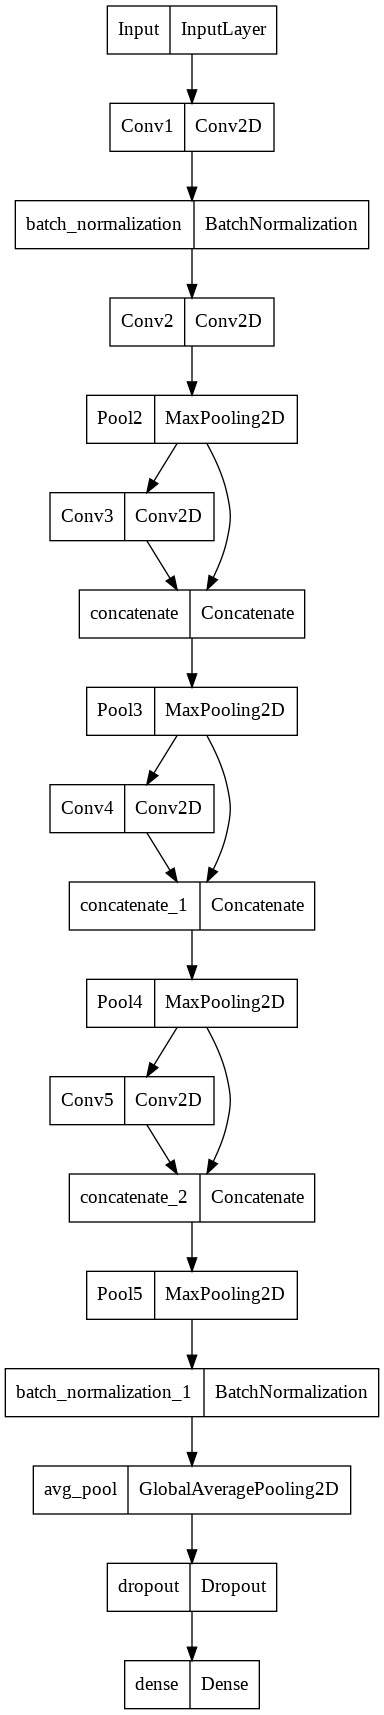

In [ ]:
# # now no 
# for i, layer in enumerate(model.layers[:n_not_trainable_layers]):
#   layer.trainable=False
# for i, layer in enumerate(supernet.layers):
#   print(i, layer.name, layer.trainable)

# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

model.summary()
tfk.utils.plot_model(model)

In [15]:
c = [tfk.callbacks.ModelCheckpoint('./ckpt_' + model_dir, save_best_only=True), tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)] 
history = model.fit(
    x = train_gen,
    batch_size = batch_size,
    epochs = 200,
    validation_data = valid_gen,
    class_weight = class_weight,
    callbacks = c
).history

Epoch 1/200
97/97 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.8828 

INFO:tensorflow:Assets written to: ./ckpt_mynet_trial_2_moreDivisionDS/assets


INFO:tensorflow:Assets written to: ./ckpt_mynet_trial_2_moreDivisionDS/assets


97/97 [==============================] - 3223s 33s/step - loss: 0.0240 - accuracy: 0.8828 - val_loss: 0.2790 - val_accuracy: 0.8947
Epoch 2/200
97/97 [==============================] - 352s 4s/step - loss: 0.0217 - accuracy: 0.8984 - val_loss: 0.3011 - val_accuracy: 0.8851
Epoch 3/200
97/97 [==============================] - 347s 4s/step - loss: 0.0217 - accuracy: 0.8989 - val_loss: 0.4119 - val_accuracy: 0.8336
Epoch 4/200
97/97 [==============================] - 340s 4s/step - loss: 0.0220 - accuracy: 0.8933 - val_loss: 0.3146 - val_accuracy: 0.8875
Epoch 5/200
97/97 [==============================] - 345s 4s/step - loss: 0.0230 - accuracy: 0.8929 - val_loss: 0.3549 - val_accuracy: 0.8631
Epoch 6/200
97/97 [==============================] - 345s 4s/step - loss: 0.0205 - accuracy: 0.9011 - val_loss: 0.4064 - val_accuracy: 0.8489
Epoch 7/200
97/97 [==============================] - 348s 4s/step - loss: 0.0214 - accuracy: 0.9038 - val_loss: 0.3591 - val_accuracy: 0.8665
Epoch 8/200
97/9

INFO:tensorflow:Assets written to: ./ckpt_mynet_trial_2_moreDivisionDS/assets


INFO:tensorflow:Assets written to: ./ckpt_mynet_trial_2_moreDivisionDS/assets


97/97 [==============================] - 352s 4s/step - loss: 0.0189 - accuracy: 0.9064 - val_loss: 0.2309 - val_accuracy: 0.9199
Epoch 9/200
97/97 [==============================] - 348s 4s/step - loss: 0.0177 - accuracy: 0.9101 - val_loss: 0.2602 - val_accuracy: 0.8836
Epoch 10/200
97/97 [==============================] - 346s 4s/step - loss: 0.0178 - accuracy: 0.9114 - val_loss: 0.4985 - val_accuracy: 0.8054
Epoch 11/200
97/97 [==============================] - 349s 4s/step - loss: 0.0186 - accuracy: 0.9059 - val_loss: 0.4661 - val_accuracy: 0.8448
Epoch 12/200
97/97 [==============================] - 347s 4s/step - loss: 0.0166 - accuracy: 0.9136 - val_loss: 0.3055 - val_accuracy: 0.8832
Epoch 13/200
97/97 [==============================] - 344s 4s/step - loss: 0.0186 - accuracy: 0.9117 - val_loss: 0.3181 - val_accuracy: 0.8788
Epoch 14/200
97/97 [==============================] - 339s 4s/step - loss: 0.0174 - accuracy: 0.9110 - val_loss: 0.3585 - val_accuracy: 0.8732
Epoch 15/200


INFO:tensorflow:Assets written to: ./ckpt_mynet_trial_2_moreDivisionDS/assets


INFO:tensorflow:Assets written to: ./ckpt_mynet_trial_2_moreDivisionDS/assets


97/97 [==============================] - 344s 4s/step - loss: 0.0157 - accuracy: 0.9166 - val_loss: 0.2232 - val_accuracy: 0.9061


In [16]:
model.save('./' + model_dir)

INFO:tensorflow:Assets written to: ./mynet_trial_2_moreDivisionDS/assets


INFO:tensorflow:Assets written to: ./mynet_trial_2_moreDivisionDS/assets


In [ ]:
# model.evaluate(test_gen, return_dict=True)

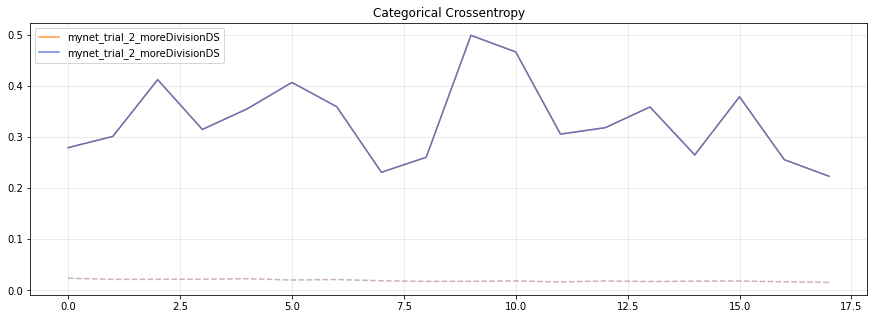

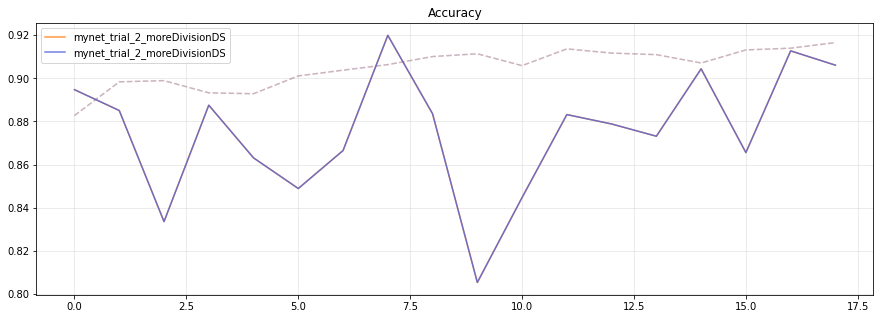

In [17]:
def compareModels(history1, h1lbl, history2=None, h2lbl=''):
  '''
  Plot history1 against history2. 
  If history2 is None then Plot twice history1 (it'll be overlapped)
  h1lbl and h2lbl are the labels of the two histories
  '''
  if history2 == None: 
    history2 = history1
    h2lbl = h1lbl
  # Plot the training
  plt.figure(figsize=(15,5))
  plt.plot(history1['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(history1['val_loss'], label=h1lbl, alpha=.8, color='#ff7f0e')
  plt.plot(history2['loss'], alpha=.3, color='#4D61E2', linestyle='--')
  plt.plot(history2['val_loss'], label=h2lbl, alpha=.8, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Categorical Crossentropy')
  plt.grid(alpha=.3)

  plt.figure(figsize=(15,5))
  plt.plot(history1['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(history1['val_accuracy'], label=h1lbl, alpha=.8, color='#ff7f0e')
  plt.plot(history2['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
  plt.plot(history2['val_accuracy'], label=h2lbl, alpha=.8, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=.3)

  plt.show()
compareModels(history, model_dir)

In [14]:
model = tf.keras.models.load_model('./' + model_dir)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(valid_gen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_gen.classes, y_pred))

Confusion Matrix
[[ 139    0    0    0    0    0    0    0    0    0    0    1    0    0
     0    0    0    0    1    0    0    0    0    0    0    1    0]
 [   0  136    0    0    0    0    0    0    1    0    0    0    1    0
     0    0    0    0    0    1    0    0    1    0    0    0    1]
 [   1    0  130    0    1    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    2    0    0    0    0]
 [   0    0    0   77    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    1    0    0    0    0    0    0    0]
 [   0    0    0    0   92    0    0    0    0    0    0    1    0    1
     0    0    0    0    0    0    0    0    0    0    0    1    0]
 [   0    0    0    0    0  106    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    1    0    0    0    0]
 [   0    0    0    0    0    1  245    0    0    0    0    0    1    0
     0    0    1    0    0    0    0    1    0    0    0    0    2]
 [ 

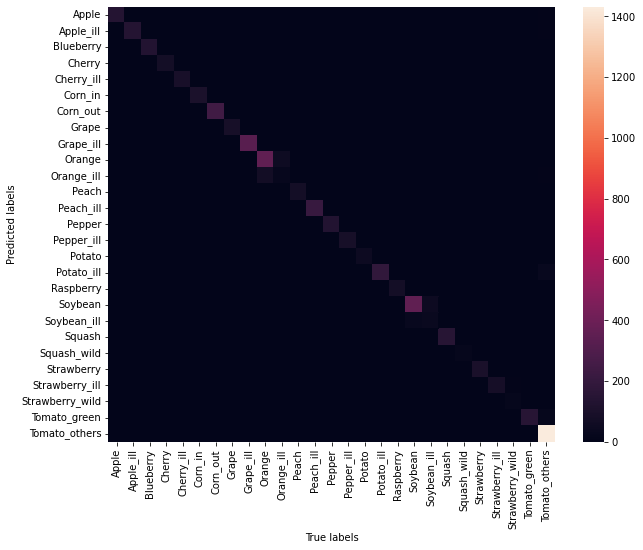

In [19]:
# Plot the confusion matrix
import seaborn as sns
cm = confusion_matrix(valid_gen.classes, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [20]:
# # Compute the classification metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
target = valid_gen.classes
predictions = Y_pred
accuracy = accuracy_score(target, np.argmax(predictions, axis=1))
precision = precision_score(target, np.argmax(predictions, axis=1), average='macro')
recall = recall_score(target, np.argmax(predictions, axis=1), average='macro')
f1 = f1_score(target, np.argmax(predictions, axis=1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

Accuracy: 0.9209
Precision: 0.8816
Recall: 0.9034
F1: 0.8905


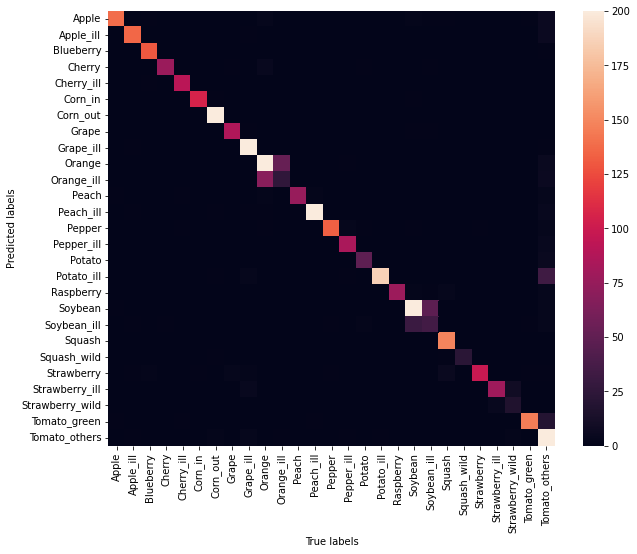

In [21]:
# Let's replot the heatmap but this time we put vmax = 200, so that tomatoes don't cloud the colors of the heatmap and we can visualize the distribution a bit better
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels, vmax=200)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

     |████████████████████████████████| 795 kB 5.3 MB/s 


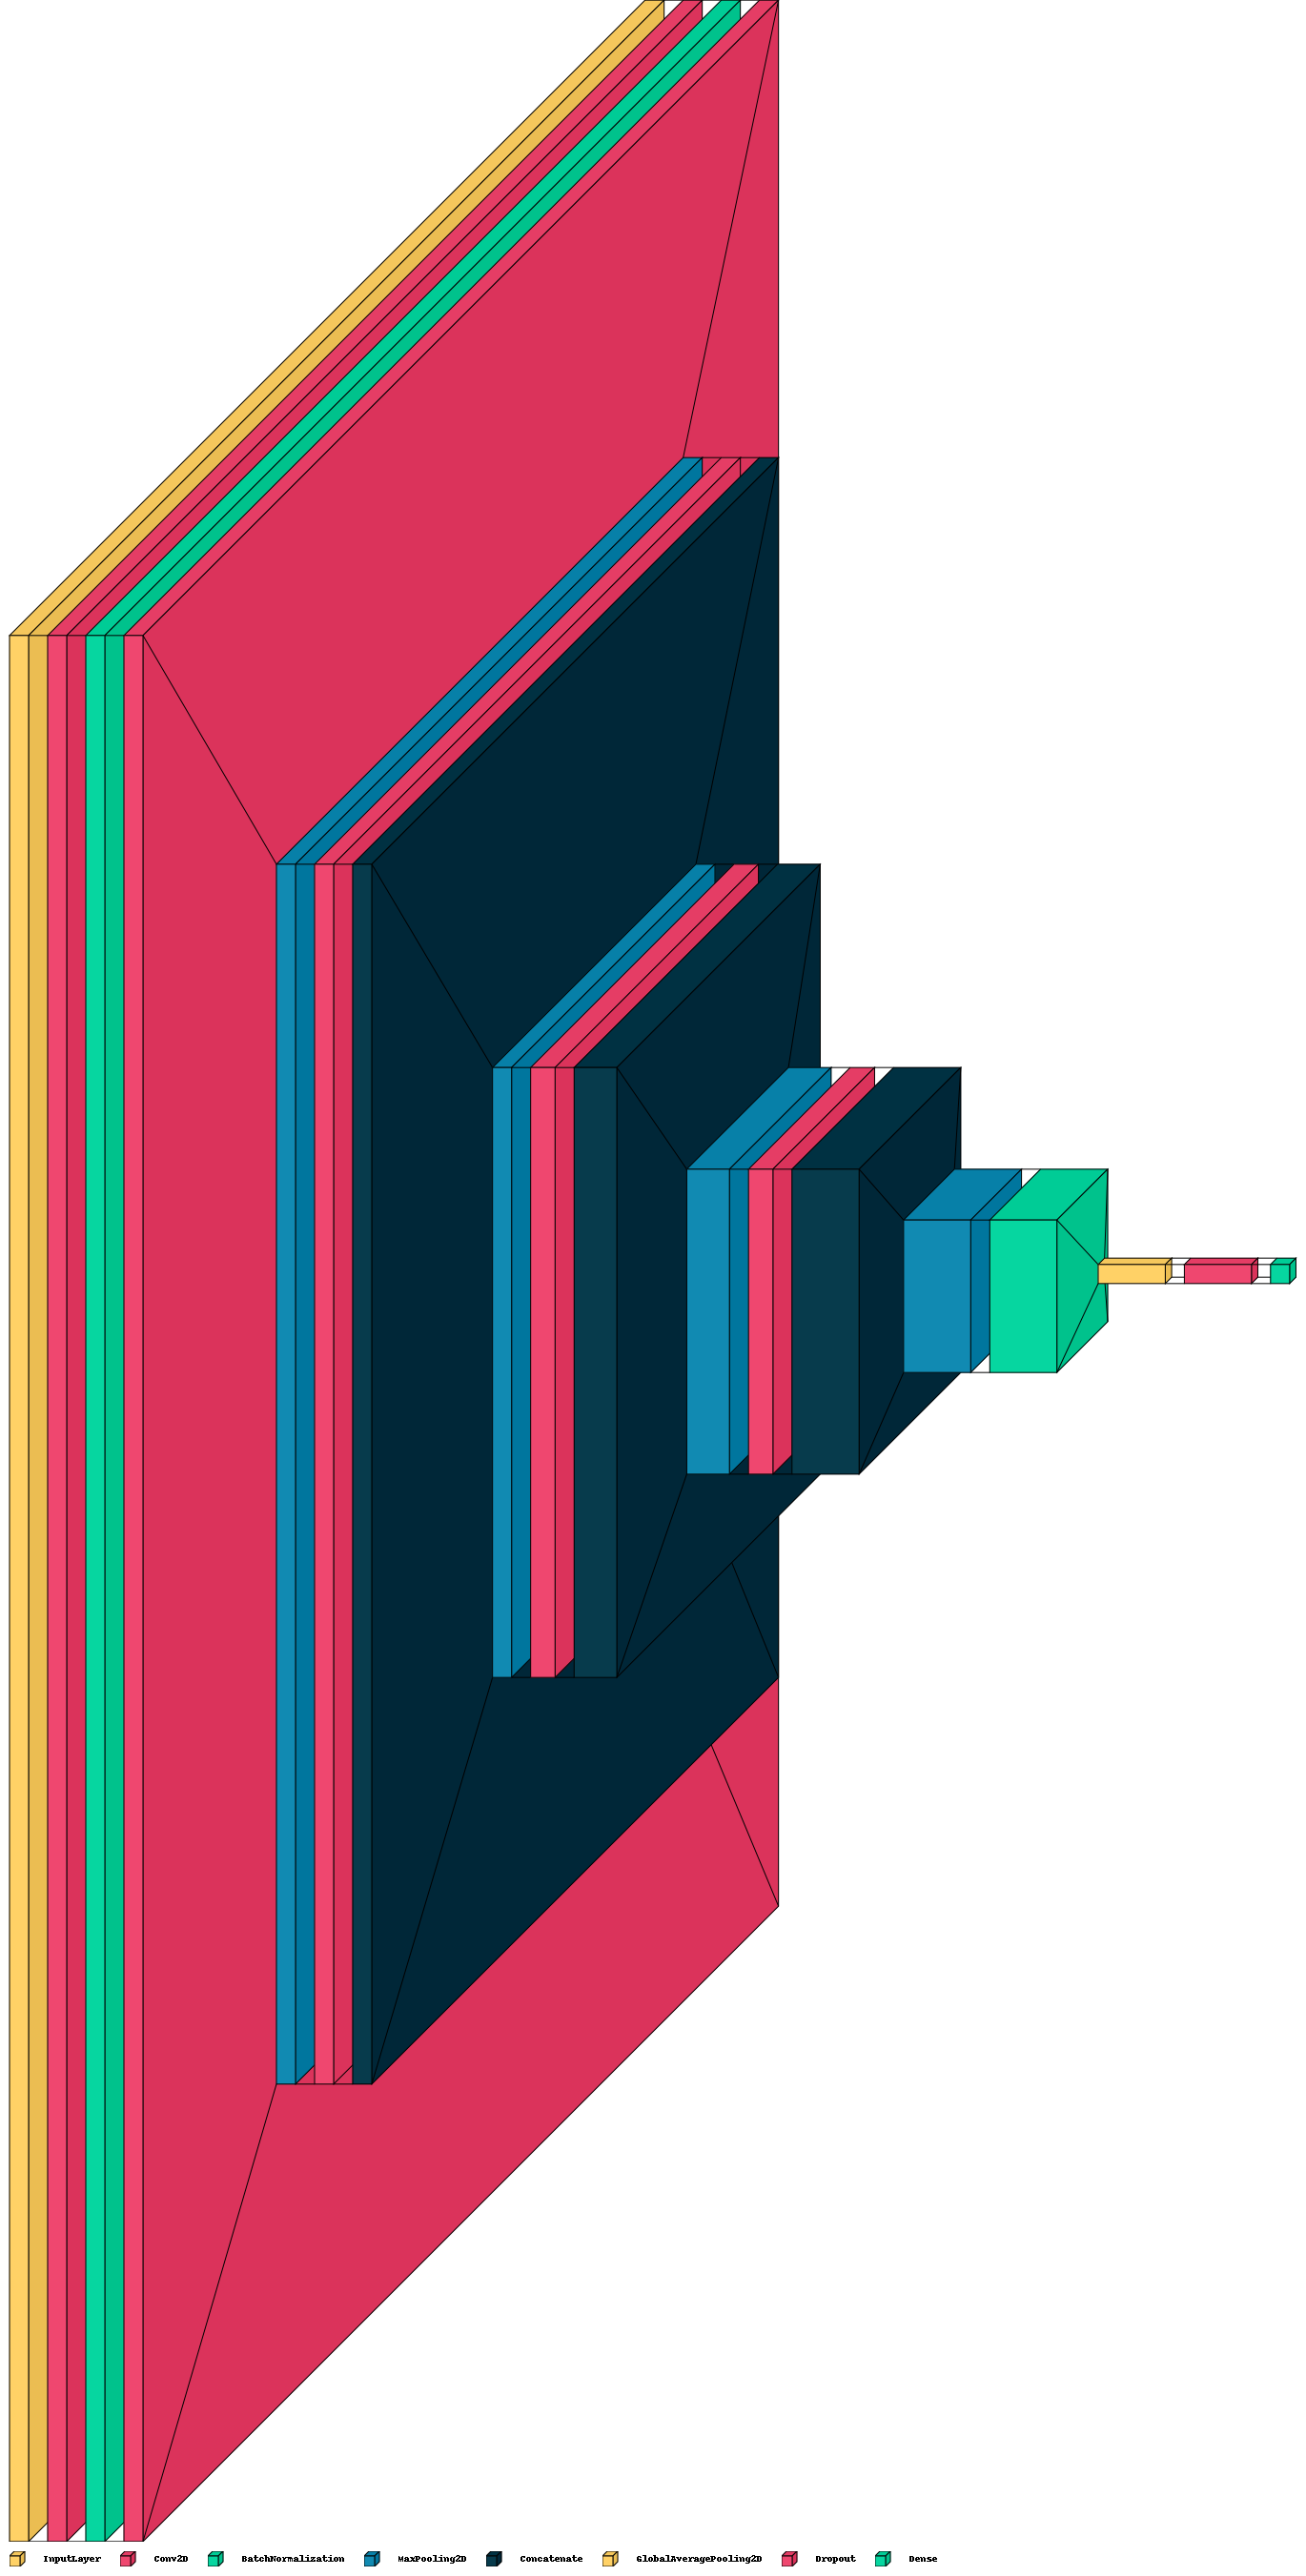

In [22]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)